In [162]:
# %pip install numpy torch torchvision

### Structure d'un programme PyTorch

Un programme PyTorch typique se compose de trois parties principales :
1. **Architecture du réseau de neurones**
2. **Entraînement**
3. **Test**

Voyons ces parties en détail.

### Description du réseau

PyTorch utilise la classe `nn.Module` comme bloc de construction des réseaux de neurones. Dans un scénario de base, vous créez une sous-classe de `nn.Module` pour définir les couches dans la méthode `__init__` et décrire le flux des données à travers celles-ci dans la méthode `forward`. Par exemple :

```python
import torch
import torch.nn as nn

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.hidden_layer = nn.Linear(2, 10)
        self.output_layer = nn.Linear(10, 5)
    
    def forward(self, x):
        x = self.hidden_layer(x)
        x = torch.relu(x)
        x = self.output_layer(x)
        return x
```

Une couche entièrement connectée est définie avec nn.Linear(n_in, n_out), où n_in et n_out sont les dimensions d'entrée et de sortie. Remarquez l'utilisation des fonctions d'activation : une couche cachée avec ReLU et une couche de sortie sans fonction d'activation.

Pour initialiser le modèle :

```python
model = MyNetwork()
```

Pour voir la sortie pour une entrée donnée :

```python
x = torch.tensor([1., 2.], dtype=torch.float32)
print(model(x))
```


### Exercice 1.1

1. **Définissez un `nn.Module` plus grand** : Incluez au moins 3 couches avec un nombre différent de neurones dans les couches cachées.  
2. **Vérifiez** que la propagation avant fonctionne : créez un tenseur et appliquez le réseau dessus. Si vous obtenez une erreur, assurez-vous que le nombre de neurones de sortie de la couche n-1 est bien égal au nombre de **neurones d'entrée** de la couche n.  

Utilisez :  
- `nn.Module` pour construire des réseaux de neurones.  
- `torch.tensor(...)` pour créer des tenseurs à partir de tableaux NumPy.  


In [163]:
from typing import Iterator
import torch
import torch.nn as nn
import torch.nn.parameter as parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)


class FeaturesEngeniringLayer(nn.Module):
    def __init__(self, in_features: int, device=None, dtype=None):
        factory_kwargs = {"device": device, "dtype": dtype}
        N = 3
        super().__init__()
        self._weigths = [
            parameter.Parameter(torch.ones((in_features, ), **factory_kwargs))
            for _ in range(N)]
        self._bias = [
            parameter.Parameter(torch.zeros((in_features, ), **factory_kwargs))
            for _ in range(N)]
        self.in_features = in_features
        self.out_features = (in_features * N)
    
    def forward(self, x:torch.Tensor):
        x_ = [(weigths * x + bias) for weigths, bias in zip(self._weigths, self._bias)]
        return torch.cat([x_[0], torch.sin(x_[1]), torch.cos(x_[2])], dim=-1)

# your code here
class MyModel(nn.Module):
    def __init__(self, nbIn:int, nbUnits:list[int|tuple[int, nn.Module]]):
        super().__init__()
        self.engineer = FeaturesEngeniringLayer(in_features=nbIn, device=device)
        nbUnits_: list[int] = [self.engineer.out_features]
        self.activations: list[nn.Module] = []
        for units in nbUnits:
            activation = nn.ReLU()
            if isinstance(units, tuple):
                units, activation = units
            nbUnits_.append(units)
            self.activations.append(activation)
        
        self.nbIn: int = nbIn
        self.nbOut: int = nbUnits_[-1]
        self.layers: list[nn.Linear] = []
        for unitsPrev, unitsLayer in zip(nbUnits_, nbUnits_[1: ]):
            self.layers.append(nn.Linear(unitsPrev, unitsLayer, device=device))
        print(f"-> {self.layers[0].in_features}(nonLinear) -> ", end="")
        print(" -> ".join(f"{l.out_features}({a.__class__.__name__})" for l, a in zip(self.layers, self.activations)))
        
    def parameters(self, recurse: bool = True) -> "Iterator[nn.Parameter]":
        for layer in self.layers:
            yield from layer.parameters(recurse=recurse)

    def forward(self, x:torch.Tensor):
        x = x.to(device)
        x = self.engineer(x)
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.in_layer = nn.Linear(2, 20)
        self.hidden_layers = [
            nn.Linear(20, 20) for _ in range(4)]
        self.output_layer = nn.Linear(20, 1)
    
    def parameters(self, recurse: bool = True) -> "Iterator[nn.Parameter]":
        yield from self.in_layer.parameters(recurse=recurse)
        for layer in self.hidden_layers:
            yield from layer.parameters(recurse=recurse)
        yield from self.output_layer.parameters(recurse=recurse)
    
    def forward(self, x):
        x = torch.relu(self.in_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

m = MyModel(2, [20, (20, nn.Tanh()), 20, 10, (3, nn.Softmax(0))])
m2 = MyNetwork()

x = torch.empty((m.nbIn, ), dtype=torch.float32).normal_()
print(m(x))
print(m2(x))


cpu
-> 6(nonLinear) -> 20(ReLU) -> 20(Tanh) -> 20(ReLU) -> 10(ReLU) -> 3(Softmax)
tensor([0.2693, 0.3222, 0.4085], grad_fn=<SoftmaxBackward0>)
tensor([0.4382], grad_fn=<SigmoidBackward0>)


### Boucle d'entraînement

Une boucle d'entraînement typique dans PyTorch comprend trois opérations principales, répétées sur plusieurs époques. Tout d'abord, vous **faites passer** des lots de données à travers le modèle pour calculer des prédictions. Ensuite, vous **calculez** une perte en comparant ces prédictions aux étiquettes réelles. Enfin, vous effectuez la **rétropropagation**, qui calcule les gradients pour chaque paramètre du modèle et les **met à jour** via l'optimiseur.  

L'optimiseur est généralement défini au début de l'entraînement et détermine **comment** les paramètres sont ajustés (par exemple, via SGD, Adam, etc.). Il est initialisé avec les paramètres entraînables du modèle (accessibles via `.parameters()`) et **met à jour leurs valeurs uniquement pendant l'entraînement** via `.step()`, après le calcul des gradients.

À noter que `model.eval()` ne modifie le comportement que de certaines couches comme `nn.Dropout` et `nn.BatchNorm`, mais il n'affecte pas directement les autres couches du modèle.

Voici un exemple concis :

```python
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(5):
    for data, labels in train_loader:
        # Forward pass (compute predictions)
        outputs = model(data)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backpropagation:
        # 1) Clear existing gradients
        optimizer.zero_grad()
        # 2) Compute gradients of the loss w.r.t. each parameter
        loss.backward()
        # 3) Update parameters based on computed gradients
        optimizer.step()

    print(f"Epoch {epoch+1} complete.")

### Exercice 1.2

1. **Examinez** la fonction `generate_two_spirals` ci-dessous. À quoi ressemblent les données ? Visualisez-les. Ce jeu de données correspond-il à une tâche de classification ou de régression ?  
2. **Choisissez une fonction de perte appropriée**, en fonction de la tâche :
   - Utilisez `nn.CrossEntropyLoss` pour une classification multi-classes.
   - Utilisez `nn.BCELoss` pour une classification binaire. (Dans ce cas, la couche de sortie doit contenir un seul neurone et avoir une activation `Sigmoid`, rendant les sorties interprétables comme des probabilités.)
   - Pour une régression, choisissez `nn.MSELoss` ou `nn.L1Loss`.  
3. **Choisissez un optimiseur**. Vous pouvez utiliser la descente de gradient stochastique standard (`optim.SGD`) ou une option plus avancée comme Adam (`optim.Adam`). N'oubliez pas de spécifier le taux d'apprentissage (`0.001` fonctionnera ici).  
4. **Implémentez une boucle d'entraînement** sur les données générées : effectuez une propagation avant pour obtenir des prédictions, calculez la perte, rétro-propagez (`loss.backward()`), et mettez à jour les paramètres (`optimizer.step()`). Répétez ce processus *des milliers de fois*. Comme le jeu de données est petit, on peut utiliser l'ensemble des données pour la descente de gradient. Cela signifie qu'il n'y a **pas** de boucle sur des mini-lots (mini-batches).  
5. **Stockez les valeurs des pertes** et visualisez-les en fonction du nombre d'itérations d'entraînement. Que remarquez-vous si vous modifiez le taux d'apprentissage ?

*Remarque* :  
En raison de la façon dont la rétropropagation est implémentée (ce que nous verrons la semaine prochaine), lors du stockage des pertes pour une visualisation ultérieure, il faut écrire `losses.append(loss.detach().item())` à la toute fin de l'étape d'entraînement.

*Remarque importante* :  
Comme l'entraînement est effectué par lots, la première dimension d'un tenseur correspond toujours à la **dimension batch**. En d'autres termes, si vos données individuelles ont la forme `(x1, x2, x3)`, alors un tenseur typique passé au réseau aura la forme `(batch_size, x1, x2, x3)`. Par exemple, regardez comment `Y` est transformé via `.reshape(-1, 1)` lorsqu'il est converti d'un tableau NumPy en tenseur. Cette dimension est implicite dans la définition d'une couche entièrement connectée.


In [164]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_two_spirals(n_points=1000, noise=0.5, random_state=42):
    np.random.seed(random_state)
    n = np.sqrt(np.random.rand(n_points,1)) * 2 *780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1)*noise
    d1y =  np.sin(n)*n + np.random.rand(n_points,1)*noise

    X = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y))))
    Y = np.hstack((np.zeros(n_points), np.ones(n_points)))
    return X, Y

X_data, y_data = generate_two_spirals(n_points=1000, noise=1.)

# splite the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# convert the data to PyTorch tensors
dtype = torch.float32
X_train_tensor = torch.tensor(X_train, dtype=dtype)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=dtype)
X_val_tensor = torch.tensor(X_val, dtype=dtype)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=dtype)

(2000, 2) (2000,)


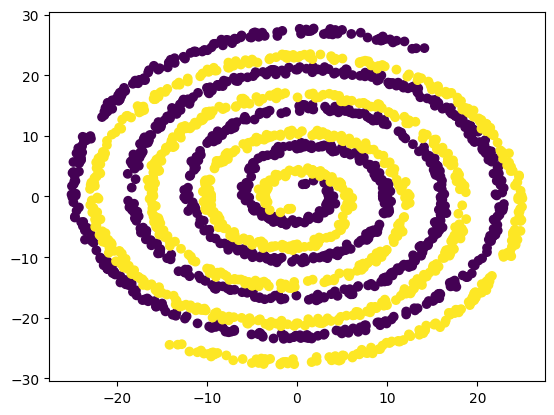

In [165]:
print(X_data.shape, y_data.shape)
import matplotlib.pyplot as plt

plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data)


In [166]:
import torch.optim as optim
def trainModel(model:MyModel, optimizer:optim.Optimizer, lossFunc:nn.Module,
               nbEpoches:int, X_train:torch.Tensor, y_train:torch.Tensor,
               X_test:torch.Tensor, y_test:torch.Tensor,
               )->tuple[np.ndarray, np.ndarray]:
    hist_train: list[float] = []
    hist_test: list[float] = []
    for epoch in range(1, nbEpoches+1):
        model.train()
        currentStats = (f"{hist_train[-1]:.3f} | {hist_test[-1]:.3f} " if epoch > 1 else "")
        print(f"\rstarting epoch n°{epoch} {currentStats}... ", end="", flush=True)
        # train
        y_pred: torch.Tensor = model(X_train)
        loss: torch.Tensor = lossFunc(y_pred, y_train.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        hist_train.append(loss.item())
        # test
        model.eval()
        with torch.no_grad():
            y_pred: torch.Tensor = model(X_test)
            loss: torch.Tensor = lossFunc(y_pred, y_test.to(device))
            hist_test.append(loss.item())
        model.train()
        
    print()
    return np.array(hist_train), np.array(hist_test)

def evalAccuracy(model:MyModel, X_val:torch.Tensor, y_val:torch.Tensor)->None:
    model.eval()
    with torch.no_grad():
        y_val_pred: torch.Tensor = model(X_val)
    model.train()
    correct = 0
    total = 0
    for label_pred, label_true in zip(
            y_val_pred.flatten().tolist(),
            y_val.flatten().tolist()):
        label_pred = round(label_pred, 0) # to clossest
        total += 1
        if label_pred == label_true:
            correct += 1
    print(f"{correct} / {total} -> {correct/total*100:.1f} %")

-> 6(nonLinear) -> 20(LeakyReLU) -> 20(LeakyReLU) -> 20(Softmax) -> 20(LeakyReLU) -> 20(LeakyReLU) -> 1(Sigmoid)
starting epoch n°1500 0.077 | 0.207 ... 
train mean: 0.0775 +/- 0.000325
test mean: 0.208 +/- 0.000585
376 / 400 -> 94.0 %


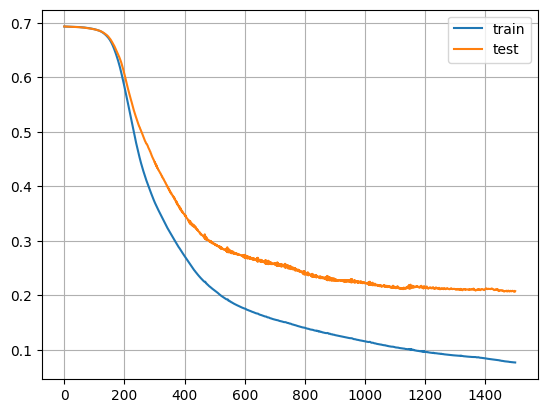

In [167]:
# your code here
loss = nn.BCELoss()
model = MyModel(2, [*([(20, nn.LeakyReLU())]*2), (20, nn.Softmax(1)), *([(20, nn.LeakyReLU())]*2), (1, nn.Sigmoid())])
optimizer = optim.Adam(model.parameters(), lr=0.0005)
nbEpoches = 1500

# more simple model (way weaker)
#model = MyNetwork()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#nbEpoches = 5000

hist_train, hist_test = trainModel(
    model, optimizer, loss, nbEpoches=nbEpoches,
    X_train=X_train_tensor, y_train=y_train_tensor,
    X_test=X_val_tensor, y_test=y_val_tensor)
N: int = 20
print(f"train mean: {hist_train[-N: ].mean():.3g} +/- {hist_train[-N: ].std():.3g}")
print(f"test mean: {hist_test[-N: ].mean():.3g} +/- {hist_test[-N: ].std():.3g}")
evalAccuracy(model, X_val_tensor, y_val_tensor)
plt.plot(hist_train, label="train")
plt.plot(hist_test, label="test")
plt.yscale("linear")
plt.legend()
plt.grid(True)



### Étape de Validation

Pendant l'entraînement, un modèle est évalué sur un jeu de validation séparé pour surveiller ses performances et détecter un éventuel sur-apprentissage (**overfitting**). Contrairement à l'entraînement, la validation **ne met pas à jour** les paramètres du modèle. Elle mesure uniquement dans quelle mesure le modèle généralise aux données non vues.

La principale différence avec l'entraînement est l'utilisation de `torch.no_grad()`. Cela désactive le suivi des gradients, ce qui réduit l'utilisation de la mémoire et accélère les calculs, puisque les gradients ne sont pas nécessaires pour l'inférence.

#### **Boucle typique de validation**

```python
# [...]

model.eval()  # Set model to evaluation mode (disables dropout, batch norm updates)

correct = 0
total = 0

with torch.no_grad():  # No need to track gradients
    for data, labels in val_loader:
        outputs = model(data)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

model.train()  # Switch back to training mode
# [...]
```


### Exercice 1.3 : Implémentation de l'étape de validation

Maintenant que votre réseau de classification est entraîné, implémentez une étape de validation pour mesurer ses performances sur des données non vues.

1. **Mettez le modèle en mode évaluation** avec `model.eval()`. Cela garantit que les couches comme `Dropout` et `BatchNorm` fonctionnent correctement (meme si on ne les utilise pas).  
2. **Désactivez le calcul des gradients** en utilisant `torch.no_grad()`. Cela réduit la consommation de mémoire et accélère les calculs.  
3. **Calculez les prédictions sur le jeu de validation** et stockez-les. Comme notre dataset est relativement petit, vous pouvez le traiter en une seule passe, sans le diviser en mini-lots.  
4. **Calculez la précision** en comparant les étiquettes prédites aux étiquettes réelles.  
5. **Affichez la précision de validation** après la boucle.  
6. **Ajustez l’architecture** du réseau afin d'atteindre une précision élevée (>0.8).  

Dans notre cas spécifique de classification binaire, vous pouvez utiliser la méthode suivante :  

```python
predictions = (model(X_val_tensor) >= 0.5).float()  # Convertit les probabilités en 0 ou 1
correct += (predictions == y_val_tensor).sum().item()  # Compte les prédictions correctes

In [168]:
# -> code above
evalAccuracy(model, X_val_tensor, y_val_tensor)

376 / 400 -> 94.0 %


## Convolutions et pooling

Les couches de convolution sont essentielles dans le traitement des images par les réseaux de neurones. Elles appliquent des filtres qui détectent des motifs comme les contours ou les textures en faisant glisser une petite matrice sur l'image. Chaque filtre met en évidence certaines caractéristiques spécifiques, comme les bords horizontaux ou verticaux. Ce processus permet au réseau de reconnaître progressivement des structures complexes.

Une fois les caractéristiques extraites, une couche de pooling réduit la taille des données tout en conservant les informations les plus importantes. Le max pooling, par exemple, sélectionne la valeur maximale dans une petite région, ce qui diminue la résolution de l’image tout en maintenant ses structures principales. Cela rend le modèle plus efficace en réduisant le nombre de paramètres et en rendant l'apprentissage plus robuste aux petites variations.

Voici un exemple qui utilise une convolution et un pooling. Lisez-le attentivement.

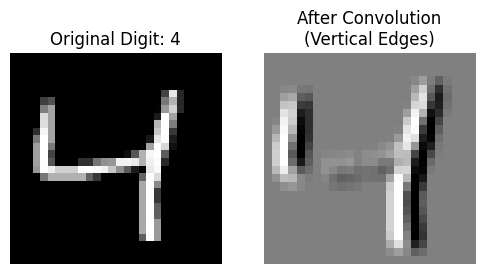

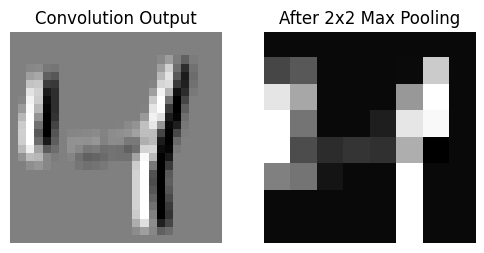

In [169]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

###############################################################################
# 1. LOAD A SINGLE MNIST IMAGE
###############################################################################
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_data = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)

# Pick one sample (image + label)
img, label = mnist_data[2]
# 'img' now has shape [1, 28, 28] (PyTorch format for grayscale images)
# 'label' is an integer digit, e.g. 5

# Reshape the image to [batch_size=1, channels=1, height=28, width=28]
img_4d = img.unsqueeze(0)  # now shape [1, 1, 28, 28]

###############################################################################
# 2. DEFINE A CUSTOM CONVOLUTION FILTER
###############################################################################
# This 3x3 filter is for detecting vertical edges.
# out_channels=1, in_channels=1, kernel_height=3, kernel_width=3
vertical_filter = torch.tensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0) 
# shape [1, 1, 3, 3]

###############################################################################
# 3. APPLY THE CONVOLUTION
###############################################################################
conv_output = F.conv2d(img_4d, vertical_filter)
# conv_output has shape [1, 1, 26, 26] (3x3 kernel reduces 28->26 in each dimension if no padding)

###############################################################################
# 4. VISUALIZE ORIGINAL DIGIT VS. CONVOLVED OUTPUT
###############################################################################
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].set_title(f"Original Digit: {label}")
ax[0].axis('off')

ax[1].imshow(conv_output.squeeze().detach().numpy(), cmap='gray')
ax[1].set_title("After Convolution\n(Vertical Edges)")
ax[1].axis('off')

plt.show()

###############################################################################
# 5. APPLY MAX POOLING
###############################################################################
pooled_output = F.max_pool2d(conv_output, kernel_size=3)
# shape becomes [1, 1, 13, 13] because 2x2 pooling halves height & width (26->13)

###############################################################################
# 6. VISUALIZE CONVOLVED VS. POOLED OUTPUT
###############################################################################
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(conv_output.squeeze().detach().numpy(), cmap='gray')
ax[0].set_title("Convolution Output")
ax[0].axis('off')

ax[1].imshow(pooled_output.squeeze().detach().numpy(), cmap='gray')
ax[1].set_title("After 2x2 Max Pooling")
ax[1].axis('off')

plt.show()


### Ex. 2.1 : Convolution avec des Kernels Personnalisés sur une Image Unique

On va comprendre comment un filtre de convolution défini manuellement modifie l’apparence d’une image en mettant en évidence certaines caractéristiques (par exemple, les contours).

1. **Sélectionner une image** : Choisissez une petite image en niveaux de gris dans votre dataset (par exemple, un chiffre de MNIST) ou créez une matrice simple de 5×5 ou 10×10.  
2. **Définir des filtres** : Créez manuellement un tenseur 3×3 détectant une caractéristique spécifique (par exemple, les bords horizontaux). Ce kernel aura la forme `[1, 1, 3, 3]`.  
   Utilisez les filtres suivants :
   
```python
    [[ 1,  1,  1],
    [  1,  1,  1],
    [  1,  1,  1]],

    [[ -1, -2, -1],
    [   0,  0,  0],
    [   1,  2,  1]],

    [[ 0,  1,  0],
    [  1, -2,  1],
    [  0,  1,  0]]

```
3. **Appliquer la convolution** : Utilisez `F.conv2d` pour appliquer la convolution entre l’image et le filtre (pensez à redimensionner votre image unique en `[1, 1, hauteur, largeur]`).  
4. **Visualiser** l’image originale et l’image convoluée côte à côte (comme dans l’exemple).  
5. **Interpréter les résultats** : Discutez des parties de l’image qui ont été mises en évidence ou atténuées par chaque filtre.  


- `torch.nn.functional.conv2d(input, weight, ...)` :
  - L’entrée doit avoir la forme `[batch_size, in_channels, H, W]`.
  - Le filtre (kernel) doit avoir la forme `[out_channels, in_channels, kH, kW]`.
- `unsqueeze(0)` : Pour redimensionner l’image d’entrée (par exemple, de `[1, 28, 28]` à `[1, 1, 28, 28]`).

---

**Remarque sur la dimension batch et les canaux** :  
Les images passées dans un réseau de neurones convolutif doivent être formatées en **4 dimensions** :  
- **Batch size** : Nombre d'images traitées en parallèle (`1` pour une seule image).  
- **Nombre de canaux** : `1` pour une image en niveaux de gris, `3` pour une image en couleur (RGB).  
- **Hauteur et largeur** : Dimensions spatiales de l’image.  

Ainsi, une image MNIST (28×28 pixels, en niveaux de gris) doit être mise en forme comme `[1, 1, 28, 28]` avant d’être traitée par `conv2d`.

9
torch.Size([1, 1, 180, 320])
torch.Size([1, 1, 180, 320]) torch.Size([1, 1, 178, 318])
1.0 0.003921568859368563


C:\Users\vuvu7\AppData\Local\Temp\ipykernel_5508\2277780750.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


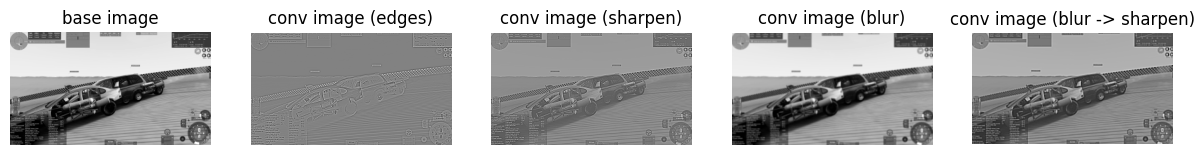

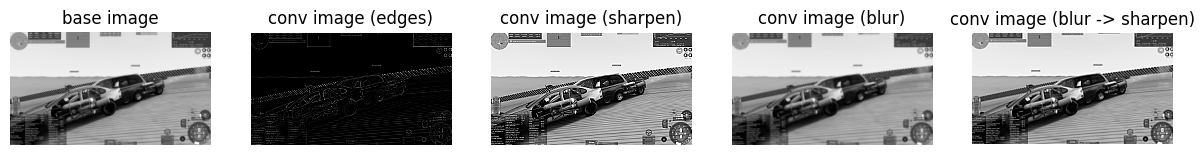

In [170]:
# votre code
img: torch.Tensor
img, label = mnist_data[154]
print(label)
kernel1 = torch.tensor([
    [0, 1, 0],
    [1, -4, 1], # edge detection
    [0, 1, 0] # (1, 1, 3, 3)
], dtype=torch.float32).unsqueeze(0).unsqueeze(0) 

kernel2 = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1], # sharpen
    [0, -1, 0] # (1, 1, 3, 3)
], dtype=torch.float32).unsqueeze(0).unsqueeze(0) 
kernel2 = kernel2 / kernel2.sum()

kernel3 = torch.tensor([
    [0, 1, 0],
    [1, 2, 1], # bluring
    [0, 1, 0] # (1, 1, 3, 3)
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
kernel3 = kernel3 / kernel3.sum()

from PIL import Image
img = torch.mean(torch.tensor(
    np.asarray(Image.open("train.png")), 
    dtype=torch.float32), dim=-1).unsqueeze(0).unsqueeze(0)
img = F.avg_pool2d(img / 255, kernel_size=8)
print(img.shape)

conv_img1 = F.conv2d(img, kernel1)
conv_img2 = F.conv2d(img, kernel2)
conv_img3 = F.conv2d(img, kernel3)
conv_img4 = F.conv2d(conv_img3, kernel2)
print(img.shape, conv_img1.shape)
print(img.max().item(), img.min().item())

def show(vmin, vmax):
    fig, ax = plt.subplots(1, 5, figsize=(3*5, 3))
    ax[0].imshow(img.squeeze().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    ax[0].set_title("base image")
    ax[0].axis('off')
    ax[1].imshow(conv_img1.squeeze().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    ax[1].set_title("conv image (edges)")
    ax[1].axis('off')
    ax[2].imshow(conv_img2.squeeze().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    ax[2].set_title("conv image (sharpen)")
    ax[2].axis('off')
    ax[3].imshow(conv_img3.squeeze().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    ax[3].set_title("conv image (blur)")
    ax[3].axis('off')
    ax[4].imshow(conv_img4.squeeze().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    ax[4].set_title("conv image (blur -> sharpen)")
    ax[4].axis('off')
    fig.show()

show(None, None)
show(0, 1)

# kernel1 and kernel2 are borders detection filters
# kernel3 is a bluring filter


### Ex. 2.2 : Effet du Stride en Convolution et Pooling  

On va comprendre comment **différentes valeurs de stride** modifient les dimensions spatiales de la sortie et comment elles ignorent certaines parties des données. En variant le stride en convolution et en pooling, on observe le compromis entre **résolution** et **coût de calcul**.

Le **stride** (ou pas) détermine de combien de pixels le filtre **se déplace** à chaque application (en convolution comme en pooling). Un **stride de 1** signifie que le filtre se déplace d’un seul pixel à la fois, produisant une carte de caractéristiques plus détaillée. Un **stride de 2** signifie que le filtre se déplace de deux pixels à la fois, sautant certaines données et réduisant ainsi la taille de la sortie.

#### **Première partie : Convolution et Pooling en 1D**  

Avant d’explorer la convolution en **2D**, il est utile de comprendre comment elle fonctionne en **1D**. Cela permet de voir plus facilement comment le stride affecte les dimensions de sortie.  

1. **Créer une séquence de nombres** : Par exemple, utilisez `torch.arange(10).float().unsqueeze(0).unsqueeze(0)` pour obtenir un tenseur `[1, 1, 10]`.  
2. **Définir un filtre simple** : Un kernel 1D `[1, 3]` avec des valeurs `torch.ones(1, 1, 3)` qui fait une somme locale.  
3. **Appliquer la convolution avec `stride=1`**, puis avec `stride=2`, et observer comment la sortie rétrécit.  
4. **Tester le max pooling** (`F.max_pool1d`) avec `stride=1` et `stride=2`, et comparer l’effet avec la convolution.

---

#### **Deuxième partie : Convolution et Pooling en 2D**  
 

1. **Créer une matrice synthétique** (ex. un tenseur 5×5 ou 8×8) avec un motif clair, comme des nombres croissants par ligne ou colonne.  
   - Utilisez `torch.arange` combiné avec `reshape` et `unsqueeze`.  
   - Exemple : `torch.arange(25).reshape(5, 5).float().unsqueeze(0).unsqueeze(0)`.  
2. **Appliquer une convolution** avec un petit filtre (ex. `torch.ones(1, 1, 3, 3)`) et `stride=1`.  
   - Notez la **forme de sortie** et observez les motifs dans le résultat.  
3. **Modifier le stride** à `2` (en gardant le même kernel).  
   - Vérifiez comment la taille de sortie diminue (ex. de **8×8** → **6×6** avec `stride=1`, et **3×3** avec `stride=2` si aucun padding n’est utilisé).  
4. **Appliquer une couche de pooling** (`F.max_pool2d` ou `F.avg_pool2d`) avec `stride=1` puis `stride=2`.  
   - Comparer l’effet du stride en pooling avec celui en convolution.  
5. **Faire une synthèse** :  
   - Observer que **plus le stride est grand, plus la sortie est petite**.  
   - Noter que **certaines informations sont ignorées** lorsque stride > 1, ce qui peut affecter la qualité des caractéristiques extraites.  

---

- **`F.conv1d(input, weight, stride=...)`** : Pour expérimenter en 1D avant de passer à 2D.  
- **`F.conv2d(input, weight, stride=...)`** : Permet de spécifier le stride comme un entier ou un tuple.  
- **`F.max_pool2d(input, kernel_size=..., stride=...)`** ou **`F.avg_pool2d(...)`** : Applique le stride de la même manière en pooling.


In [171]:
datas = torch.arange(11).float().unsqueeze(0).unsqueeze(0)
kernel = torch.ones(1, 1, 3)
conv1_datas = torch.conv1d(datas, kernel, stride=1)
conv2_datas = torch.conv1d(datas, kernel, stride=2)
print(conv1_datas.squeeze(), conv2_datas.squeeze())

max_datas = torch.max_pool1d(datas, kernel_size=2)
avg_datas = torch.avg_pool1d(datas, kernel_size=2)
print(max_datas.squeeze(), avg_datas.squeeze())


tensor([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27.]) tensor([ 3.,  9., 15., 21., 27.])
tensor([1., 3., 5., 7., 9.]) tensor([0.5000, 2.5000, 4.5000, 6.5000, 8.5000])


### Exercice 2.3 (Bonus) : Réseau CNN avec Réduction Progressive de la Résolution  

Dans cet exercice, nous allons empiler **plusieurs couches de convolution et de pooling** pour observer comment cela réduit progressivement les dimensions spatiales tout en construisant des représentations plus riches de l’image.

---

### **1) Définir un CNN avec 2–3 étapes**  

Un modèle de base pourrait être construit comme suit :  

- **Étape 1** : `Conv2d(1, 8, kernel_size=3) -> ReLU -> MaxPool2d(kernel_size=2)`
- **Étape 2** : `Conv2d(8, 16, kernel_size=3) -> ReLU -> MaxPool2d(kernel_size=2)`
- **(Optionnel) Étape 3** : `Conv2d(16, 32, kernel_size=3) -> ReLU -> MaxPool2d(kernel_size=2)`
- **Couches finales** : `Flatten -> Linear -> Sortie (classes de chiffres)`  

⚠ **Attention** : Pour aplatir (`Flatten`) la sortie avant d’envoyer les données à une couche linéaire, utilisez la commande suivante :  
```python
x = x.view(x.size(0), -1)  # Conserve la dimension batch
```
### **2) Entraîner le modèle sur MNIST**  

Lancez l'entraînement pendant quelques époques et observez la performance.

---

### **3) Vérifier les tailles des cartes de caractéristiques**  

Ajoutez des affichages (`print`) après chaque étape pour voir comment la taille de la sortie évolue.  

- **Entrée :** 28×28  
- **Après Étape 1 :** 13×13 (*sans padding*)  
- **Après Étape 2 :** 5×5  
- **Après Étape 3 (optionnel) :** 1×1  

---

### **4) Comparer trois architectures différentes**  

Testez plusieurs configurations pour voir l’impact sur la **précision et la vitesse d’apprentissage**. Par exemple :  
- Supprimer une étape pour voir si un modèle plus simple est suffisant.  
- Remplacer **MaxPooling** par une **convolution avec stride=2** pour voir comment cela affecte les performances.  
- Augmenter le nombre de filtres à chaque étape pour améliorer l’extraction des caractéristiques.  

Les **réseaux plus profonds** atteignent généralement une meilleure précision, mais prennent plus de temps à entraîner.

Utilisez :  
- `nn.Conv2d(input_channels, output_channels, kernel_size)` pour les convolutions.  
- `nn.MaxPool2d(kernel_size)` pour le pooling.  

### **Comment utiliser `torch.utils.data.DataLoader`**  

#### **Pourquoi l'utiliser ?**
- Regroupe les données en **mini-lots** pour améliorer l’efficacité de l'entraînement.  
- Mélange les échantillons à chaque époque (**shuffle=True**) pour éviter l'ordre fixe des données.  
- Peut charger les données en parallèle (**num_workers**) pour accélérer le traitement.  

#### **Exemple d'utilisation**
1. **Charger un dataset** (`torchvision.datasets.MNIST`).  
2. **L'emballer** dans un `DataLoader` en spécifiant `batch_size`, `shuffle`, etc.  
3. **L'itérer** dans une boucle pour récupérer les **batches** `(data, labels)`.  

```python
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
train_dataset = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for images, labels in train_loader:
    # Étape d'entraînement ici
```

In [179]:
def trainModelBatched(
        model:MyModel, optimizer:optim.Optimizer, lossFunc:nn.CrossEntropyLoss,
        nbEpoches:int, train_loader:torch.utils.data.DataLoader,
        test_loader:torch.utils.data.DataLoader)->tuple[np.ndarray, np.ndarray, np.ndarray]:
    hist_train: list[float] = []
    hist_test: list[float] = []
    hist_acc: list[float] = []
    for epoch in range(1, nbEpoches+1):
        model.train()
        currentStats = (f"{hist_train[-1]:.3f} | {hist_test[-1]:.3f} | {hist_acc[-1]:.1%}" if epoch > 1 else "")
        print(f"\rstarting epoch n°{epoch} {currentStats}... ", end="", flush=True)
        # train
        epoch_train_loss: list[float] = []
        for (X_train, labels_train) in train_loader:
            y_pred: torch.Tensor = model(X_train)
            loss: torch.Tensor = lossFunc(y_pred, labels_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())
            #break
        hist_train.append(sum(epoch_train_loss) / len(epoch_train_loss))
        # test
        model.eval()
        epoch_test_loss: list[float] = []
        correct: int = 0
        total: int = 0
        with torch.no_grad():
            for (X_test, labels_test) in test_loader:
                y_pred: torch.Tensor = model(X_test)
                # loss
                loss: torch.Tensor = lossFunc(y_pred, labels_test)
                epoch_test_loss.append(loss.item())
                # acc
                labels_pred = y_pred.argmax(dim=1)
                total += len(labels_pred)
                correct += (labels_test == labels_pred).sum().item()
                #break
        hist_test.append(sum(epoch_test_loss) / len(epoch_test_loss))
        hist_acc.append(correct / total)
        model.train()
        
    print()
    return np.array(hist_train), np.array(hist_test), np.array(hist_acc)


def runModel(
        model:nn.Module, train_loader:torch.utils.data.DataLoader,
        test_loader:torch.utils.data.DataLoader):
    print(f"running train&test on: {model}")
    
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    hist_train, hist_test, hist_acc = trainModelBatched(
        model=model, optimizer=optimizer, lossFunc=loss, nbEpoches=10,
        train_loader=train_loader, test_loader=test_loader)

    print(f"last train: {hist_train[-1]:.3g} | last test: {hist_test[-1]:.3g} | last acc: {hist_acc[-1]:.1%}")

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    ax[0].set_title(f"model: {model}")
    ax[0].plot(hist_train, label="train")
    ax[0].plot(hist_test, label="test")
    ax[1].plot(hist_acc, label="accuracy")
    for a in ax: a.grid(True)
    fig.legend()
    plt.show()
    

In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1_024*4)

test_data = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1_024*4)


class Flatten(nn.Module):
    def forward(self, x:torch.Tensor):
        return x.view(x.size(0), -1)


class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers: list[nn.Module] = [
            # -> (1, 8, 26, 26) -> (1, 8, 13, 13)
            nn.Conv2d(1, 8, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (1, 16, 11, 11) -> (1, 16, 5, 5)
            nn.Conv2d(8, 16, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (1, 32, 3, 3) -> (1, 32, 1, 1)
            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (32) -> (20) -> (10) ->
            Flatten(), nn.Linear(32, 20), nn.Linear(20, 10),
        ]
    
    def parameters(self, recurse: bool = True) -> "Iterator[nn.Parameter]":
        for layer in self.layers:
            yield from layer.parameters(recurse=recurse)

    def forward(self, x:torch.Tensor):
        if len(x.shape) < 4:
            x = x.view(1, *x.shape)
        for layer in self.layers:
            x = layer(x)
        return x


In [174]:
class MyModel2_1LayerLess(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers: list[nn.Module] = [
            # -> (1, 8, 26, 26) -> (1, 8, 13, 13)
            nn.Conv2d(1, 8, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (1, 16, 11, 11) -> (1, 16, 5, 5)
            nn.Conv2d(8, 16, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (16*5²) -> (20) -> (10) ->
            Flatten(), nn.Linear(5*5*16, 20), nn.Linear(20, 10),
        ]
    
    def parameters(self, recurse: bool = True) -> "Iterator[nn.Parameter]":
        for layer in self.layers:
            yield from layer.parameters(recurse=recurse)

    def forward(self, x:torch.Tensor):
        if len(x.shape) < 4:
            x = x.view(1, *x.shape)
        for layer in self.layers:
            x = layer(x)
        return x

In [175]:
class MyModel2_moreChannels(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers: list[nn.Module] = [
            # -> (1, 16, 26, 26) -> (1, 16, 13, 13)
            nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (1, 64, 11, 11) -> (1, 64, 5, 5)
            nn.Conv2d(16, 64, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (1, 256, 3, 3) -> (1, 256, 1, 1)
            nn.Conv2d(64, 256, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            # -> (256) -> (20) -> (10) ->
            Flatten(), nn.Linear(256, 20), nn.Linear(20, 10),
        ]
    
    def parameters(self, recurse: bool = True) -> "Iterator[nn.Parameter]":
        for layer in self.layers:
            yield from layer.parameters(recurse=recurse)

    def forward(self, x:torch.Tensor):
        if len(x.shape) < 4:
            x = x.view(1, *x.shape)
        for layer in self.layers:
            x = layer(x)
        return x


In [176]:
class MyModel2_noMaxPool(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers: list[nn.Module] = [
            # -> (1, 16, 13, 13)
            nn.Conv2d(1, 8, kernel_size=3, stride=2), nn.ReLU(),
            # -> (1, 16, 6, 6)
            nn.Conv2d(8, 16, kernel_size=3, stride=2), nn.ReLU(),
            # -> (1, 32, 2, 2)
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            # -> (32*2²) -> (20) -> (10) ->
            Flatten(), nn.Linear(32*2*2, 20), nn.Linear(20, 10),
        ]
    
    def parameters(self, recurse: bool = True) -> "Iterator[nn.Parameter]":
        for layer in self.layers:
            yield from layer.parameters(recurse=recurse)

    def forward(self, x:torch.Tensor):
        if len(x.shape) < 4:
            x = x.view(1, *x.shape)
        for layer in self.layers:
            x = layer(x)
        return x


running train&test on: MyModel2()
starting epoch n°10 0.549 | 0.464 | 85.3%... 
last train: 0.491 | last test: 0.415 | last acc: 86.6%


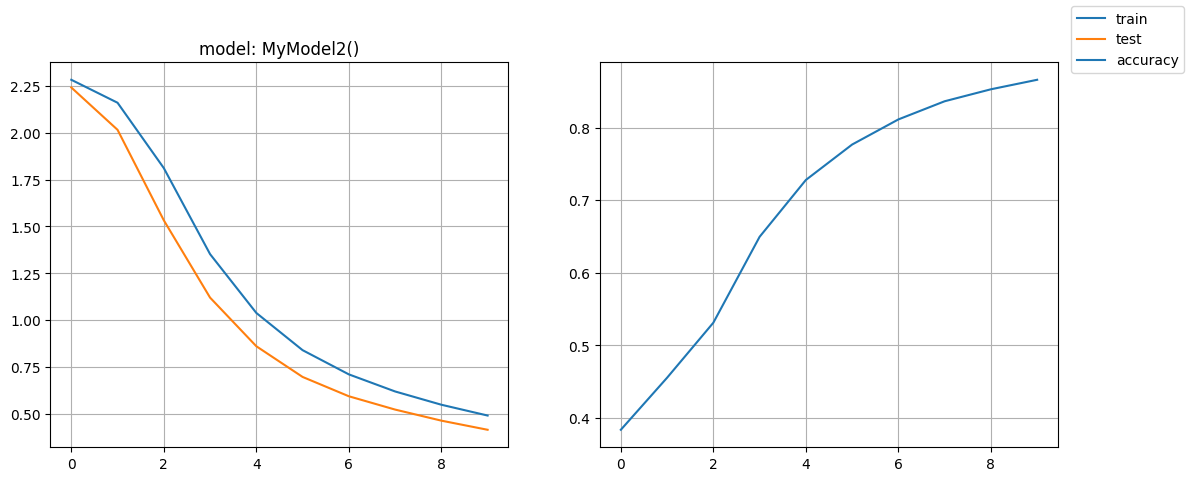

In [177]:
runModel(MyModel2(), train_loader=train_loader, test_loader=test_loader)


running train&test on: MyModel2_1LayerLess()
starting epoch n°10 0.298 | 0.256 | 92.2%... 
last train: 0.273 | last test: 0.235 | last acc: 92.8%


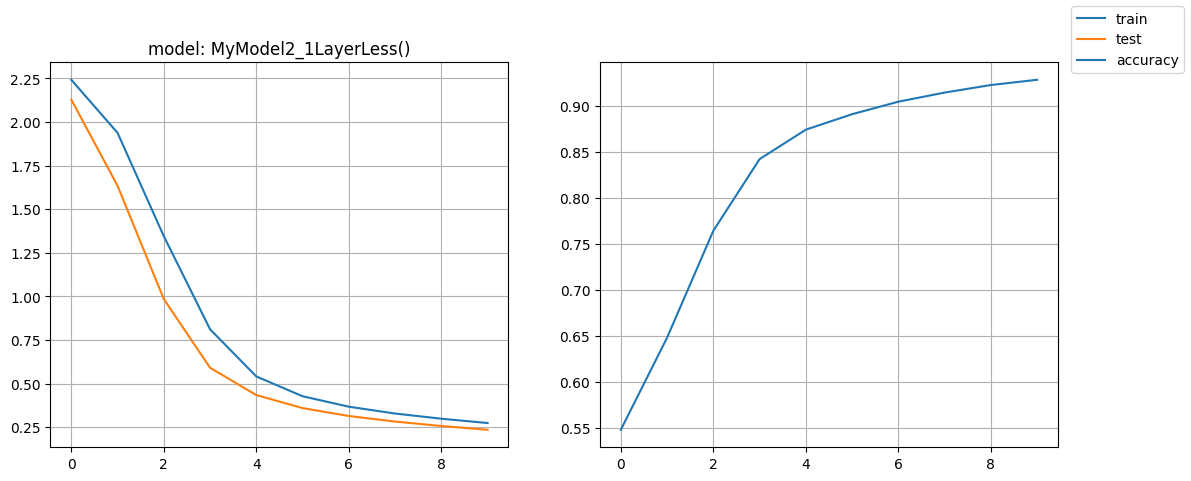

In [180]:
runModel(MyModel2_1LayerLess(), train_loader=train_loader, test_loader=test_loader)

running train&test on: MyModel2_noMaxPool()
starting epoch n°10 0.394 | 0.344 | 89.4%... 
last train: 0.37 | last test: 0.323 | last acc: 90.0%


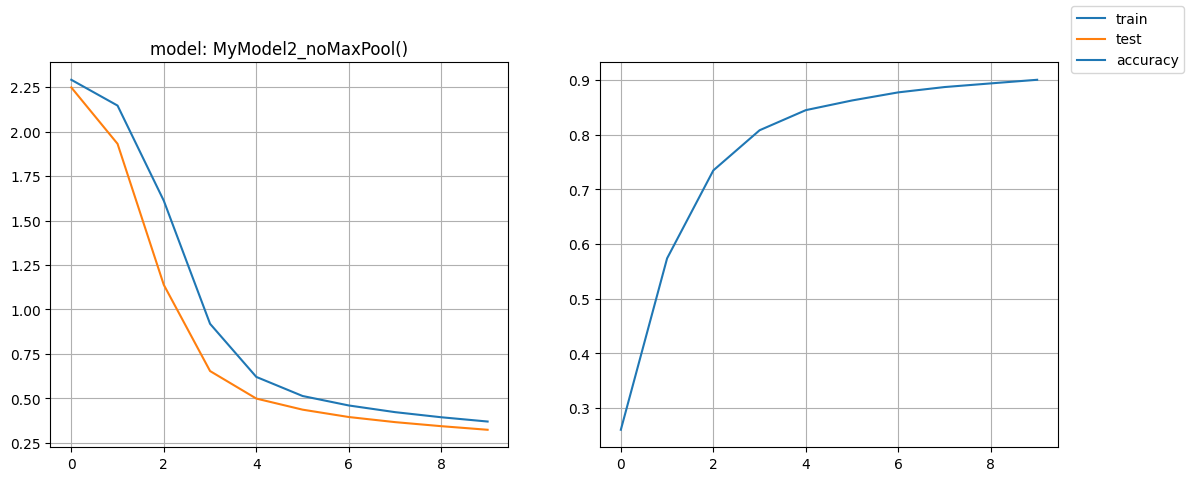

In [181]:
runModel(MyModel2_noMaxPool(), train_loader=train_loader, test_loader=test_loader)

running train&test on: MyModel2_moreChannels()
starting epoch n°10 0.173 | 0.145 | 95.3%... 
last train: 0.158 | last test: 0.133 | last acc: 95.8%


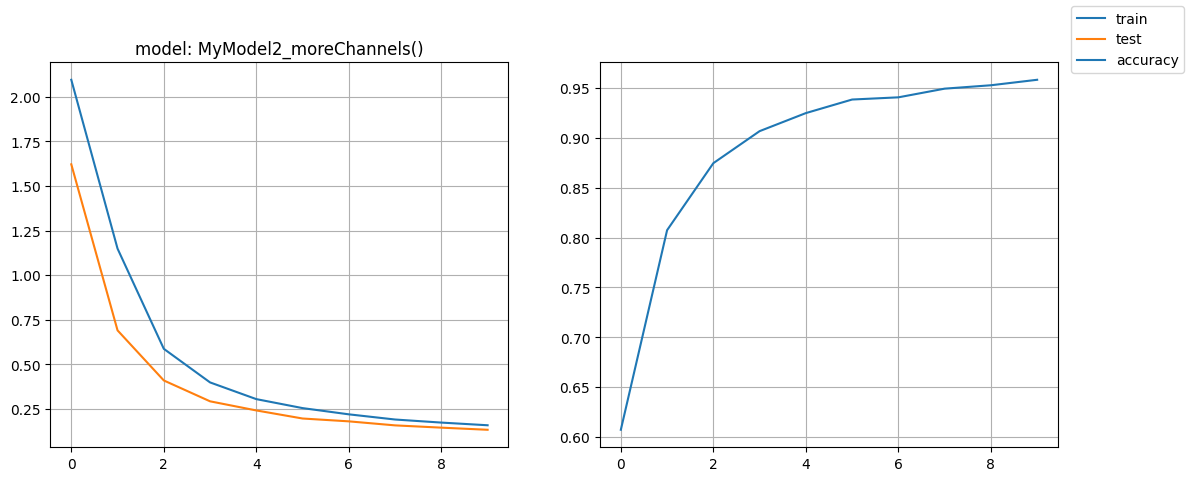

In [182]:
runModel(MyModel2_moreChannels(), train_loader=train_loader, test_loader=test_loader)